# LSTM Forecasting of ETH-USD Price Series (Short- and Long-Term Horizons)
**Dataset**: ETH-USD historical prices  
**Goal**: Построить и исследовать модель на основе LSTM для прогнозирования курса Ethereum (ETH-USD) по историческим данным.  
Анализируется качество прогноза на различных горизонтах: 1, 5, 15, 30, 90, 180 и 365 дней.  

**В рамках работы:**
- Реализована модель LSTM с настройкой параметров (окно, слои, dropout и др.)
- Проведен гиперпараметрический тюнинг с Ray Tune и ASHA Scheduler
- Построен прогноз «один шаг вперед» на тестовой выборке (1-day forward)
- Реализован итеративный прогноз на произвольный горизонт (5, 30, 365 дней)
- Построены графики прогноза vs реальность, включая долгосрочные расхождения
- Проверены seq2seq модели для horizon-aware предсказаний
- Проанализировано качество модели, ошибки и возможности улучшения (добавление признаков, encoder-decoder и пр.)

**Фреймворк**: PyTorch  
**Библиотеки**: Ray Tune, scikit-learn, matplotlib, NumPy, pandas  
**Датасет**: Исторические котировки ETH-USD  

---

_Ноутбук подготовлен в рамках курса «Искусственный интеллект и глубокое обучение» (магистратура)._


In [1]:
# !pip install yfinance pandas matplotlib torch ray[tune]

## Загрузка и подготовка данных

Загружаем исторические котировки ETH-USD через библиотеку yfinance. Далее очищаем MultiIndex, извлекаем нужные признаки и применяем нормализацию.

Особенности:
- Используем MinMaxScaler для шкалирования
- Удаляем лишние уровни индекса
- Преобразуем данные к формату, пригодному для обучения


In [2]:
import yfinance as yf
import pandas as pd

# Скачиваем данные ETH-USD
df = yf.download('ETH-USD', start='2017-01-01', interval='1d').reset_index()

df.to_parquet('eth_usd.parquet', index=False)

df_parquet = pd.read_parquet('eth_usd.parquet')

print(df_parquet.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


  ('Date', '')  ('Close', 'ETH-USD')  ('High', 'ETH-USD')  ('Low', 'ETH-USD')  \
0   2017-11-09            320.884003           329.451996          307.056000   
1   2017-11-10            299.252991           324.717987          294.541992   
2   2017-11-11            314.681000           319.453003          298.191986   
3   2017-11-12            307.907990           319.153015          298.513000   
4   2017-11-13            316.716003           328.415009          307.024994   

   ('Open', 'ETH-USD')  ('Volume', 'ETH-USD')  
0           308.644989              893249984  
1           320.670990              885985984  
2           298.585999              842300992  
3           314.690002             1613479936  
4           307.024994             1041889984  


In [3]:
# Преобразуем multi-index columns в обычные
df.columns = [col[0] for col in df.columns]
print(df.head())


        Date       Close        High         Low        Open      Volume
0 2017-11-09  320.884003  329.451996  307.056000  308.644989   893249984
1 2017-11-10  299.252991  324.717987  294.541992  320.670990   885985984
2 2017-11-11  314.681000  319.453003  298.191986  298.585999   842300992
3 2017-11-12  307.907990  319.153015  298.513000  314.690002  1613479936
4 2017-11-13  316.716003  328.415009  307.024994  307.024994  1041889984


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
print(df.dtypes)

Date      datetime64[ns]
Close            float64
High             float64
Low              float64
Open             float64
Volume             int64
dtype: object


### EDA и Feature Engineering

Добавим простые технические индикаторы (скользящие средние), которые помогут модели улавливать тренды и структуру временного ряда.

Важно: все признаки должны быть приведены к сопоставимому масштабу перед подачей в модель LSTM.


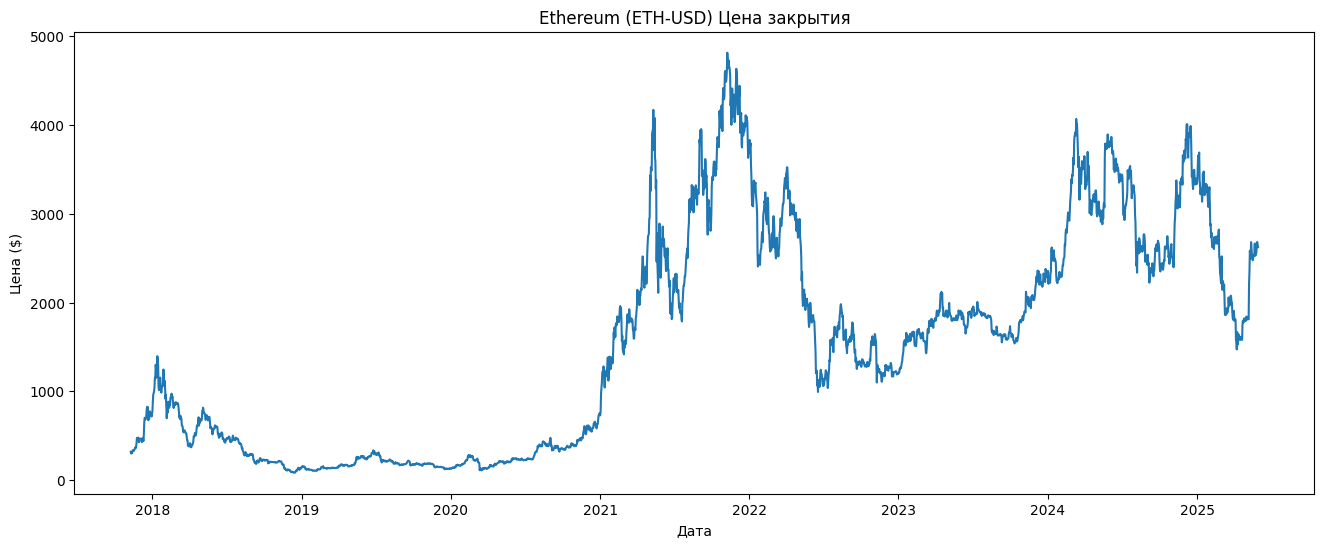

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.plot(df['Date'], df['Close'])
plt.title('Ethereum (ETH-USD) Цена закрытия')
plt.xlabel('Дата')
plt.ylabel('Цена ($)')
plt.show()


2.2. Добавим технические индикаторы (скользящие средние)
Это поможет LSTM лучше видеть тренды, волатильность и уровни поддержки/сопротивления.

In [6]:
# Скользящие средние
df['SMA_7'] = df['Close'].rolling(window=7).mean()
df['SMA_21'] = df['Close'].rolling(window=21).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# Экспоненциальная скользящая средняя
df['EMA_21'] = df['Close'].ewm(span=21, adjust=False).mean()

# Стандартное отклонение за 21 день (волатильность)
df['STD_21'] = df['Close'].rolling(window=21).std()


In [7]:
print(df.tail(10))

           Date        Close         High          Low         Open  \
2749 2025-05-20  2524.173096  2585.619873  2446.446777  2529.135010   
2750 2025-05-21  2552.347168  2614.060791  2454.537842  2524.159180   
2751 2025-05-22  2664.156982  2691.102295  2546.434814  2552.766846   
2752 2025-05-23  2526.441895  2731.220703  2504.873535  2664.082031   
2753 2025-05-24  2530.646240  2575.131348  2516.018066  2526.387939   
2754 2025-05-25  2551.763916  2553.869141  2467.880127  2530.890137   
2755 2025-05-26  2564.138428  2598.566650  2530.321533  2551.380859   
2756 2025-05-27  2663.069824  2712.285156  2512.588623  2564.140869   
2757 2025-05-28  2682.212891  2688.742188  2611.160889  2663.010254   
2758 2025-05-30  2624.313965  2642.967773  2568.047363  2631.678711   

           Volume        SMA_7       SMA_21       SMA_50       EMA_21  \
2749  23453322578  2531.506522  2243.156471  1918.206187  2302.491144   
2750  31952904125  2523.261370  2279.278936  1931.143301  2325.205328   

Для LSTM важно, чтобы все признаки были на сопоставимых масштабах!

#### Масштабирование признаков
Используем `MinMaxScaler` для нормализации всех входных признаков.

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Список используемых признаков (исключая целевую)
feature_cols = ['Close', 'High', 'Low', 'Open', 'Volume',
                'SMA_7', 'SMA_21', 'SMA_50', 'EMA_21', 'STD_21']

# Удаляем строки с NaN (появились после скользящих средних)
df = df.dropna().reset_index(drop=True)

# Масштабируем только фичи
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[feature_cols])

# Для обратного преобразования прогноза сохраняем отдельный scaler только для Close
target_scaler = MinMaxScaler()
scaled_close = target_scaler.fit_transform(df[['Close']])


#### Формирование скользящих окон
Создаем временные окна фиксированной длины (например, 30 дней), где каждый элемент содержит N дней истории и 1 целевое значение.


In [9]:
import numpy as np

window_size = 30  # потом подберем оптимальный
X = []
y = []

for i in range(window_size, len(scaled_features)):
    X.append(scaled_features[i-window_size:i])
    y.append(scaled_close[i])  # прогнозируем Close

X, y = np.array(X), np.array(y)
print('Shape X:', X.shape, 'Shape y:', y.shape)


Shape X: (2680, 30, 10) Shape y: (2680, 1)


#### Разделение на обучающую и тестовую выборку
Делим данные на обучающую (80%) и тестовую (20%) части без перемешивания, чтобы сохранить хронологию.

In [10]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


### Dataset и DataLoader

#### TimeSeriesDataset
Создаем кастомный `Dataset` на основе PyTorch, который возвращает окна с временным рядом и соответствующими целевыми значениями.



In [11]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


#### DataLoader'ы
Создаем DataLoader для обучения и валидации с необходимым `batch_size`.

In [12]:
batch_size = 64

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


### Определение модели

Реализуем LSTM-модель с параметрами: hidden_size, num_layers, dropout. Будем использовать ее для однодневного или многодневного прогноза курса ETH.


In [13]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)  # out: [batch, seq_len, hidden]
        out = out[:, -1, :]    # берем только последний таймстеп
        out = self.fc(out)
        return out


Пример создания модели:

In [14]:
input_size = X.shape[2]   # 10 признаков
hidden_size = 64          # можно тюнить
num_layers = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)


### Шаг 6. Обучение и валидация

Реализуем функцию обучения (`train`) и валидации (`evaluate`), где модель обучается на обучающем сете и тестируется на отложенных данных.


#### Функции обучения и оценки

In [15]:
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import numpy as np

# Функция для обучения модели на одной эпохе
def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()   # Обнуляем градиенты
        output = model(X_batch)
        loss = criterion(output, y_batch)  # Считаем функцию потерь
        loss.backward()         # Вычисляем градиенты
        optimizer.step()        # Обновляем параметры модели

        total_loss += loss.item()   # Накопление ошибки по батчам
    return total_loss / len(loader) # Возвращаем средний лосс по эпохе

# Функция для оценки модели на валидационных данных
def evaluate(model, loader, criterion, device):
    model.eval()  # Переводим модель в режим оценки
    total_loss = 0
    preds = []
    targets = []
    with torch.no_grad():  # Отключаем вычисление градиентов для ускорения
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            total_loss += loss.item()

            preds.append(output.cpu().numpy())
            targets.append(y_batch.cpu().numpy())

    preds = np.concatenate(preds)       # Объединяем все предсказания в один массив
    targets = np.concatenate(targets)   # Объединяем все предсказания в один массив
    rmse = np.sqrt(mean_squared_error(targets, preds))  # Считаем RMSE

    return total_loss / len(loader), rmse, preds, targets

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()  # Среднеквадратичная ошибка
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 50
train_losses = []
val_losses = []
val_rmses = []

# Основной цикл обучения и валидации
for epoch in range(n_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)   # Обучение
    val_loss, val_rmse, _, _ = evaluate(model, test_loader, criterion, device)  # Оценка на валидации

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_rmses.append(val_rmse)

    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f} | RMSE: {val_rmse:.2f}")

Epoch 1/50 | Train Loss: 0.03284 | Val Loss: 0.00428 | RMSE: 0.07
Epoch 2/50 | Train Loss: 0.00227 | Val Loss: 0.00293 | RMSE: 0.05
Epoch 3/50 | Train Loss: 0.00181 | Val Loss: 0.00239 | RMSE: 0.05
Epoch 4/50 | Train Loss: 0.00146 | Val Loss: 0.00184 | RMSE: 0.04
Epoch 5/50 | Train Loss: 0.00129 | Val Loss: 0.00172 | RMSE: 0.04
Epoch 6/50 | Train Loss: 0.00134 | Val Loss: 0.00151 | RMSE: 0.04
Epoch 7/50 | Train Loss: 0.00106 | Val Loss: 0.00158 | RMSE: 0.04
Epoch 8/50 | Train Loss: 0.00097 | Val Loss: 0.00147 | RMSE: 0.04
Epoch 9/50 | Train Loss: 0.00090 | Val Loss: 0.00124 | RMSE: 0.04
Epoch 10/50 | Train Loss: 0.00090 | Val Loss: 0.00137 | RMSE: 0.04
Epoch 11/50 | Train Loss: 0.00098 | Val Loss: 0.00418 | RMSE: 0.06
Epoch 12/50 | Train Loss: 0.00089 | Val Loss: 0.00136 | RMSE: 0.04
Epoch 13/50 | Train Loss: 0.00077 | Val Loss: 0.00107 | RMSE: 0.03
Epoch 14/50 | Train Loss: 0.00077 | Val Loss: 0.00105 | RMSE: 0.03
Epoch 15/50 | Train Loss: 0.00074 | Val Loss: 0.00114 | RMSE: 0.03
Epoc

Шаг 7. Визуализация результатов (исходные vs прогноз)

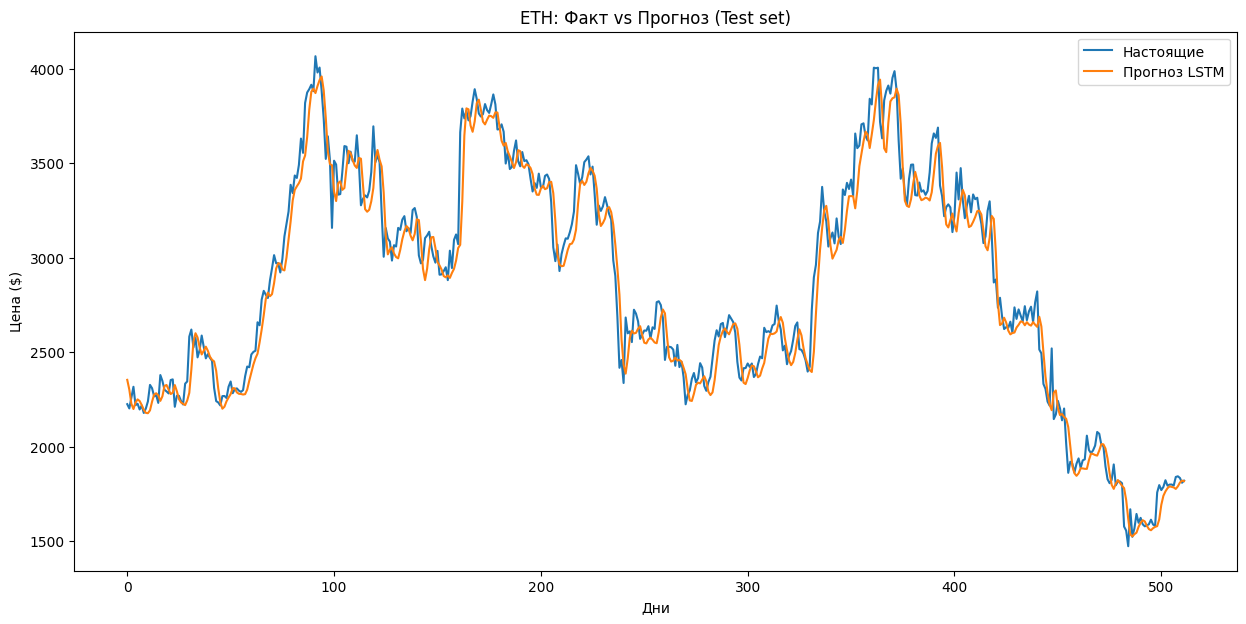

In [17]:
import matplotlib.pyplot as plt

# Получим все предсказания на тесте
_, _, preds, targets = evaluate(model, test_loader, criterion, device)

# Восстановим масштабы
preds_rescaled = target_scaler.inverse_transform(preds)
targets_rescaled = target_scaler.inverse_transform(targets)

plt.figure(figsize=(15, 7))
plt.plot(targets_rescaled, label='Настоящие')
plt.plot(preds_rescaled, label='Прогноз LSTM')
plt.title('ETH: Факт vs Прогноз (Test set)')
plt.xlabel('Дни')
plt.ylabel('Цена ($)')
plt.legend()
plt.show()


Прогноз на следующий временной шаг (future)

In [18]:
# Берем последние window_size строк из исходных данных (из скалированных фич)
last_window = scaled_features[-window_size:]  # shape: (window_size, 10)
last_window = np.expand_dims(last_window, axis=0)  # для batch dimension

last_window_tensor = torch.tensor(last_window, dtype=torch.float32).to(device)

with torch.no_grad():
    next_pred_scaled = model(last_window_tensor).cpu().numpy()

# Обратно в цену
next_pred = target_scaler.inverse_transform(next_pred_scaled)
print(f'Прогноз цены ETH на следующий день: {next_pred[0][0]:.2f} $')


Прогноз цены ETH на следующий день: 2586.14 $


Мы напишем функцию, которая принимает гиперпараметры и каждый запуск делает обучение + валидацию.

Импорт Ray Tune и определение функции

In [ ]:
# !pip install ray[tune]

In [22]:
import ray
print(ray.__version__)


2.46.0


In [23]:
print(type(scaled_features))
print(type(scaled_close))
print(TimeSeriesDataset)
print(LSTMModel)
print(train)
print(evaluate)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class '__main__.TimeSeriesDataset'>
<class '__main__.LSTMModel'>
<function train at 0x7acf05196660>
<function evaluate at 0x7acf05102700>


### Подбор гиперпараметров (Ray Tune)


In [24]:
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.air import session

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Класс для представления датасета временного ряда, наследует от torch.utils.data.Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Определение LSTM-модели на PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Используем только последний временной шаг
        out = self.fc(out)
        return out

# Функция для обучения модели на одну эпоху
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Функция для оценки модели (валидация)
from sklearn.metrics import mean_squared_error
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    preds = []
    targets = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            total_loss += loss.item()
            preds.append(output.cpu().numpy())
            targets.append(y_batch.cpu().numpy())
    preds = np.concatenate(preds)
    targets = np.concatenate(targets)
    rmse = np.sqrt(mean_squared_error(targets, preds))
    return total_loss / len(loader), rmse, preds, targets


In [25]:
# Основная функция, которую будет вызывать Ray Tune для подбора гиперпараметров
def train_lstm_tune(config):
    window_size = config['window_size']

    # Формируем обучающие и тестовые выборки с нужным window_size
    X_local, y_local = [], []
    for i in range(window_size, len(scaled_features)):
        X_local.append(scaled_features[i-window_size:i])
        y_local.append(scaled_close[i])
    X_local, y_local = np.array(X_local), np.array(y_local)

    split = int(0.8 * len(X_local))
    X_train_l, X_test_l = X_local[:split], X_local[split:]
    y_train_l, y_test_l = y_local[:split], y_local[split:]

    # Оборачиваем данные в Dataset и DataLoader для батчей
    train_dataset = TimeSeriesDataset(X_train_l, y_train_l)
    test_dataset = TimeSeriesDataset(X_test_l, y_test_l)
    train_loader = DataLoader(train_dataset, batch_size=int(config["batch_size"]), shuffle=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=int(config["batch_size"]), shuffle=False, drop_last=True)

    # Инициализация модели с параметрами из config
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = LSTMModel(
        input_size=X_local.shape[2],
        hidden_size=int(config["hidden_size"]),
        num_layers=int(config["num_layers"]),
        output_size=1,
        dropout=float(config["dropout"])
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=float(config["lr"]))

    # Быстрое обучение на нескольких эпохах для Ray Tune
    for epoch in range(10):
        train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Оценка модели на валидации и отчет в Ray Tune
    val_loss, val_rmse, _, _ = evaluate(model, test_loader, criterion, device)
    session.report({"val_rmse": val_rmse})


Используем Ray Tune и ASHAScheduler для оптимизации ключевых параметров модели:
- Длина окна (window_size)
- Размер скрытого слоя (hidden_size)
- Кол-во LSTM-слоев (num_layers)
- Dropout
- Learning Rate
- Размер батча


In [26]:
# Задаем сетку и диапазоны гиперпараметров для поиска:
config = {
    "window_size": tune.choice([10, 20, 30, 40, 60]),
    "hidden_size": tune.choice([32, 64, 128, 256]),
    "num_layers": tune.choice([1, 2, 3]),
    "dropout": tune.uniform(0.1, 0.5),
    "lr": tune.loguniform(1e-4, 1e-2),
    "batch_size": tune.choice([32, 64, 128])
}

# Инициализация асинхронного гипербенд-расписания
scheduler = ASHAScheduler(metric="val_rmse", mode="min")

# Запуск гиперпараметрического поиска с использованием Ray Tune
analysis = tune.run(
    train_lstm_tune,
    resources_per_trial={"cpu": 2, "gpu": 1 if torch.cuda.is_available() else 0},
    config=config,
    num_samples=20,
    scheduler=scheduler
)

print("Best config: ", analysis.get_best_config(metric="val_rmse", mode="min"))

2025-05-30 04:14:46,523	INFO worker.py:1888 -- Started a local Ray instance.
2025-05-30 04:14:47,829	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.


+------------------------------------------------------------------------+
| Configuration for experiment     train_lstm_tune_2025-05-30_04-14-47   |
+------------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                 |
| Scheduler                        AsyncHyperBandScheduler               |
| Number of trials                 20                                    |
+------------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_lstm_tune_2025-05-30_04-14-47
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-05-30_04-14-43_669599_197/artifacts/2025-05-30_04-14-47/train_lstm_tune_2025-05-30_04-14-47/driver_artifacts`

Trial status: 20 PENDING
Current time: 2025-05-30 04:14:48. Total running time: 0s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------

(train_lstm_tune pid=1508) /usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4484705382657571 and num_layers=1
(train_lstm_tune pid=1508)   warnings.warn(



Trial train_lstm_tune_9fd57_00001 finished iteration 1 at 2025-05-30 04:15:04. Total running time: 16s
+------------------------------------------------------+
| Trial train_lstm_tune_9fd57_00001 result             |
+------------------------------------------------------+
| checkpoint_dir_name                                  |
| time_this_iter_s                             2.97095 |
| time_total_s                                 2.97095 |
| training_iteration                                 1 |
| val_rmse                                     0.04755 |
+------------------------------------------------------+

Trial train_lstm_tune_9fd57_00001 completed after 1 iterations at 2025-05-30 04:15:04. Total running time: 16s

Trial train_lstm_tune_9fd57_00002 started with configuration:
+------------------------------------------------------+
| Trial train_lstm_tune_9fd57_00002 config             |
+------------------------------------------------------+
| batch_size                         

(train_lstm_tune pid=1869) /usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3159175653652935 and num_layers=1
(train_lstm_tune pid=1869)   warnings.warn(



Trial train_lstm_tune_9fd57_00004 finished iteration 1 at 2025-05-30 04:15:35. Total running time: 46s
+------------------------------------------------------+
| Trial train_lstm_tune_9fd57_00004 result             |
+------------------------------------------------------+
| checkpoint_dir_name                                  |
| time_this_iter_s                             1.85452 |
| time_total_s                                 1.85452 |
| training_iteration                                 1 |
| val_rmse                                     0.04427 |
+------------------------------------------------------+

Trial train_lstm_tune_9fd57_00004 completed after 1 iterations at 2025-05-30 04:15:35. Total running time: 46s

Trial train_lstm_tune_9fd57_00005 started with configuration:
+------------------------------------------------------+
| Trial train_lstm_tune_9fd57_00005 config             |
+------------------------------------------------------+
| batch_size                         

(train_lstm_tune pid=1978) /usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1758579873564405 and num_layers=1
(train_lstm_tune pid=1978)   warnings.warn(



Trial train_lstm_tune_9fd57_00005 finished iteration 1 at 2025-05-30 04:15:43. Total running time: 55s
+------------------------------------------------------+
| Trial train_lstm_tune_9fd57_00005 result             |
+------------------------------------------------------+
| checkpoint_dir_name                                  |
| time_this_iter_s                             3.38927 |
| time_total_s                                 3.38927 |
| training_iteration                                 1 |
| val_rmse                                      0.0299 |
+------------------------------------------------------+

Trial train_lstm_tune_9fd57_00005 completed after 1 iterations at 2025-05-30 04:15:43. Total running time: 55s

Trial status: 6 TERMINATED | 14 PENDING
Current time: 2025-05-30 04:15:48. Total running time: 1min 0s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------

(train_lstm_tune pid=2307) /usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.21488139715189614 and num_layers=1
(train_lstm_tune pid=2307)   warnings.warn(



Trial train_lstm_tune_9fd57_00008 finished iteration 1 at 2025-05-30 04:16:07. Total running time: 1min 19s
+------------------------------------------------------+
| Trial train_lstm_tune_9fd57_00008 result             |
+------------------------------------------------------+
| checkpoint_dir_name                                  |
| time_this_iter_s                             2.22089 |
| time_total_s                                 2.22089 |
| training_iteration                                 1 |
| val_rmse                                     0.04611 |
+------------------------------------------------------+

Trial train_lstm_tune_9fd57_00008 completed after 1 iterations at 2025-05-30 04:16:07. Total running time: 1min 19s

Trial train_lstm_tune_9fd57_00009 started with configuration:
+------------------------------------------------------+
| Trial train_lstm_tune_9fd57_00009 config             |
+------------------------------------------------------+
| batch_size               

(train_lstm_tune pid=2756) /usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.46830866526731707 and num_layers=1
(train_lstm_tune pid=2756)   warnings.warn(



Trial train_lstm_tune_9fd57_00012 finished iteration 1 at 2025-05-30 04:16:43. Total running time: 1min 55s
+------------------------------------------------------+
| Trial train_lstm_tune_9fd57_00012 result             |
+------------------------------------------------------+
| checkpoint_dir_name                                  |
| time_this_iter_s                             2.87671 |
| time_total_s                                 2.87671 |
| training_iteration                                 1 |
| val_rmse                                     0.02663 |
+------------------------------------------------------+

Trial train_lstm_tune_9fd57_00012 completed after 1 iterations at 2025-05-30 04:16:43. Total running time: 1min 55s

Trial status: 13 TERMINATED | 7 PENDING
Current time: 2025-05-30 04:16:48. Total running time: 2min 0s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------

(train_lstm_tune pid=2986) /usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.28124030617655255 and num_layers=1
(train_lstm_tune pid=2986)   warnings.warn(



Trial train_lstm_tune_9fd57_00014 finished iteration 1 at 2025-05-30 04:17:00. Total running time: 2min 11s
+------------------------------------------------------+
| Trial train_lstm_tune_9fd57_00014 result             |
+------------------------------------------------------+
| checkpoint_dir_name                                  |
| time_this_iter_s                             1.87582 |
| time_total_s                                 1.87582 |
| training_iteration                                 1 |
| val_rmse                                     0.04912 |
+------------------------------------------------------+

Trial train_lstm_tune_9fd57_00014 completed after 1 iterations at 2025-05-30 04:17:00. Total running time: 2min 11s

Trial train_lstm_tune_9fd57_00015 started with configuration:
+------------------------------------------------------+
| Trial train_lstm_tune_9fd57_00015 config             |
+------------------------------------------------------+
| batch_size               

(train_lstm_tune pid=3203) /usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.42749336531361415 and num_layers=1
(train_lstm_tune pid=3203)   warnings.warn(



Trial train_lstm_tune_9fd57_00016 finished iteration 1 at 2025-05-30 04:17:16. Total running time: 2min 27s
+------------------------------------------------------+
| Trial train_lstm_tune_9fd57_00016 result             |
+------------------------------------------------------+
| checkpoint_dir_name                                  |
| time_this_iter_s                             2.90009 |
| time_total_s                                 2.90009 |
| training_iteration                                 1 |
| val_rmse                                     0.03208 |
+------------------------------------------------------+

Trial train_lstm_tune_9fd57_00016 completed after 1 iterations at 2025-05-30 04:17:16. Total running time: 2min 27s

Trial status: 17 TERMINATED | 3 PENDING
Current time: 2025-05-30 04:17:18. Total running time: 2min 30s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+------------------------------------------------------------------------------

2025-05-30 04:17:42,584	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_lstm_tune_2025-05-30_04-14-47' in 0.0119s.



Trial train_lstm_tune_9fd57_00019 finished iteration 1 at 2025-05-30 04:17:42. Total running time: 2min 54s
+------------------------------------------------------+
| Trial train_lstm_tune_9fd57_00019 result             |
+------------------------------------------------------+
| checkpoint_dir_name                                  |
| time_this_iter_s                             3.24551 |
| time_total_s                                 3.24551 |
| training_iteration                                 1 |
| val_rmse                                     0.03093 |
+------------------------------------------------------+

Trial train_lstm_tune_9fd57_00019 completed after 1 iterations at 2025-05-30 04:17:42. Total running time: 2min 54s

Trial status: 20 TERMINATED
Current time: 2025-05-30 04:17:42. Total running time: 2min 54s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+------------------------------------------------------------------------------------------

### Финальное обучение

Используем лучшую конфигурацию из Ray Tune для обучения финальной модели. Обучаем модель с увеличенным числом эпох и сохраняем веса.


In [27]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

# --- 1. Класс Dataset ---
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# --- 2. LSTM-модель ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# --- 3. Функция train ---
def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# --- 4. Функция evaluate ---
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    preds = []
    targets = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            total_loss += loss.item()
            preds.append(output.cpu().numpy())
            targets.append(y_batch.cpu().numpy())
    preds = np.concatenate(preds)
    targets = np.concatenate(targets)
    rmse = np.sqrt(np.mean((preds - targets) ** 2))
    return total_loss / len(loader), rmse, preds, targets

# --- 5. Лучшие гиперпараметры ---
best_config = {
    'window_size': 40,
    'hidden_size': 128,
    'num_layers': 1,
    'dropout': 0.10324027412649356,
    'lr': 0.0026641938836984816,
    'batch_size': 32
}

# --- 6. Генерация окон с новым window_size ---
window_size = best_config['window_size']
X_best, y_best = [], []
for i in range(window_size, len(scaled_features)):
    X_best.append(scaled_features[i-window_size:i])
    y_best.append(scaled_close[i])
X_best, y_best = np.array(X_best), np.array(y_best)

split = int(0.8 * len(X_best))
X_train_b, X_test_b = X_best[:split], X_best[split:]
y_train_b, y_test_b = y_best[:split], y_best[split:]

train_dataset = TimeSeriesDataset(X_train_b, y_train_b)
test_dataset = TimeSeriesDataset(X_test_b, y_test_b)
train_loader = DataLoader(train_dataset, batch_size=best_config["batch_size"], shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=best_config["batch_size"], shuffle=False, drop_last=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = LSTMModel(
    input_size=X_best.shape[2],
    hidden_size=best_config["hidden_size"],
    num_layers=best_config["num_layers"],
    output_size=1,
    dropout=best_config["dropout"]
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_config["lr"])

n_epochs = 50

for epoch in range(n_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_rmse, _, _ = evaluate(model, test_loader, criterion, device)
    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f} | RMSE: {val_rmse:.5f}")


Epoch 1/50 | Train Loss: 0.00773 | Val Loss: 0.00362 | RMSE: 0.06014
Epoch 2/50 | Train Loss: 0.00090 | Val Loss: 0.00224 | RMSE: 0.04738
Epoch 3/50 | Train Loss: 0.00077 | Val Loss: 0.00105 | RMSE: 0.03241
Epoch 4/50 | Train Loss: 0.00057 | Val Loss: 0.00114 | RMSE: 0.03374
Epoch 5/50 | Train Loss: 0.00046 | Val Loss: 0.00121 | RMSE: 0.03475
Epoch 6/50 | Train Loss: 0.00049 | Val Loss: 0.00179 | RMSE: 0.04227
Epoch 7/50 | Train Loss: 0.00050 | Val Loss: 0.00116 | RMSE: 0.03412
Epoch 8/50 | Train Loss: 0.00041 | Val Loss: 0.00070 | RMSE: 0.02645
Epoch 9/50 | Train Loss: 0.00037 | Val Loss: 0.00066 | RMSE: 0.02562
Epoch 10/50 | Train Loss: 0.00043 | Val Loss: 0.00062 | RMSE: 0.02491
Epoch 11/50 | Train Loss: 0.00040 | Val Loss: 0.00060 | RMSE: 0.02445
Epoch 12/50 | Train Loss: 0.00037 | Val Loss: 0.00059 | RMSE: 0.02421
Epoch 13/50 | Train Loss: 0.00035 | Val Loss: 0.00088 | RMSE: 0.02973
Epoch 14/50 | Train Loss: 0.00039 | Val Loss: 0.00054 | RMSE: 0.02322
Epoch 15/50 | Train Loss: 0.0

### Визуализация прогноза

Сравниваем прогноз модели с реальными значениями на тестовой выборке. Построим график: факт vs прогноз, чтобы визуально оценить точность.


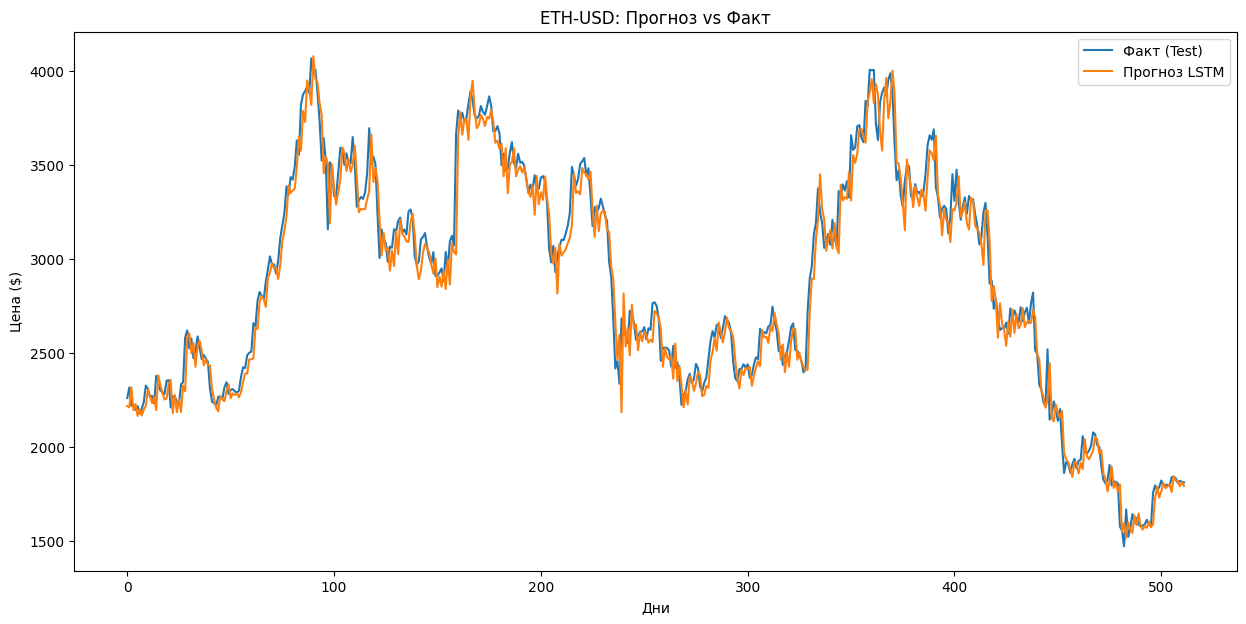

In [28]:
# Получим предсказания на тесте
_, _, preds, targets = evaluate(model, test_loader, criterion, device)

# Восстановим исходный масштаб
preds_rescaled = target_scaler.inverse_transform(preds)
targets_rescaled = target_scaler.inverse_transform(targets)

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.plot(targets_rescaled, label='Факт (Test)')
plt.plot(preds_rescaled, label='Прогноз LSTM')
plt.title('ETH-USD: Прогноз vs Факт')
plt.xlabel('Дни')
plt.ylabel('Цена ($)')
plt.legend()
plt.show()


## Краткосрочный прогноз (один шаг вперед)

Модель предсказывает цену ETH на следующий день на основе последнего окна входных данных.  
Сравниваем предсказание с реальными значениями.


In [29]:
# Прогноз на следующий день
last_window = scaled_features[-window_size:]
last_window = np.expand_dims(last_window, axis=0)
last_window_tensor = torch.tensor(last_window, dtype=torch.float32).to(device)

with torch.no_grad():
    next_pred_scaled = model(last_window_tensor).cpu().numpy()

next_pred = target_scaler.inverse_transform(next_pred_scaled)
print(f'Прогноз ETH на следующий день: {next_pred[0][0]:.2f} $')


Прогноз ETH на следующий день: 2523.97 $


In [30]:
# model.load_state_dict(torch.load('lstm_eth_model.pth'))
torch.save(model.state_dict(), 'lstm_eth_model.pth')


In [31]:
future_steps = 5  # На сколько дней хотим прогнозировать
future_preds = []

current_window = scaled_features[-window_size:].copy()  # Последнее окно

for _ in range(future_steps):
    input_tensor = torch.tensor(current_window[np.newaxis, ...], dtype=torch.float32).to(device)
    with torch.no_grad():
        next_scaled = model(input_tensor).cpu().numpy()
    next_real = target_scaler.inverse_transform(next_scaled)
    future_preds.append(next_real[0, 0])

    # ВАЖНО: используем скаляр next_scaled[0,0] для Close
    next_features = current_window[-1].copy()
    next_features[0] = next_scaled[0, 0]  # <-- вот так! (раньше было: next_scaled)
    current_window = np.vstack([current_window[1:], next_features])

print(f'Прогноз ETH на {future_steps} дней вперед: {np.round(future_preds, 2)}')


Прогноз ETH на 5 дней вперед: [2523.97 2561.16 2595.38 2618.9  2617.1 ]


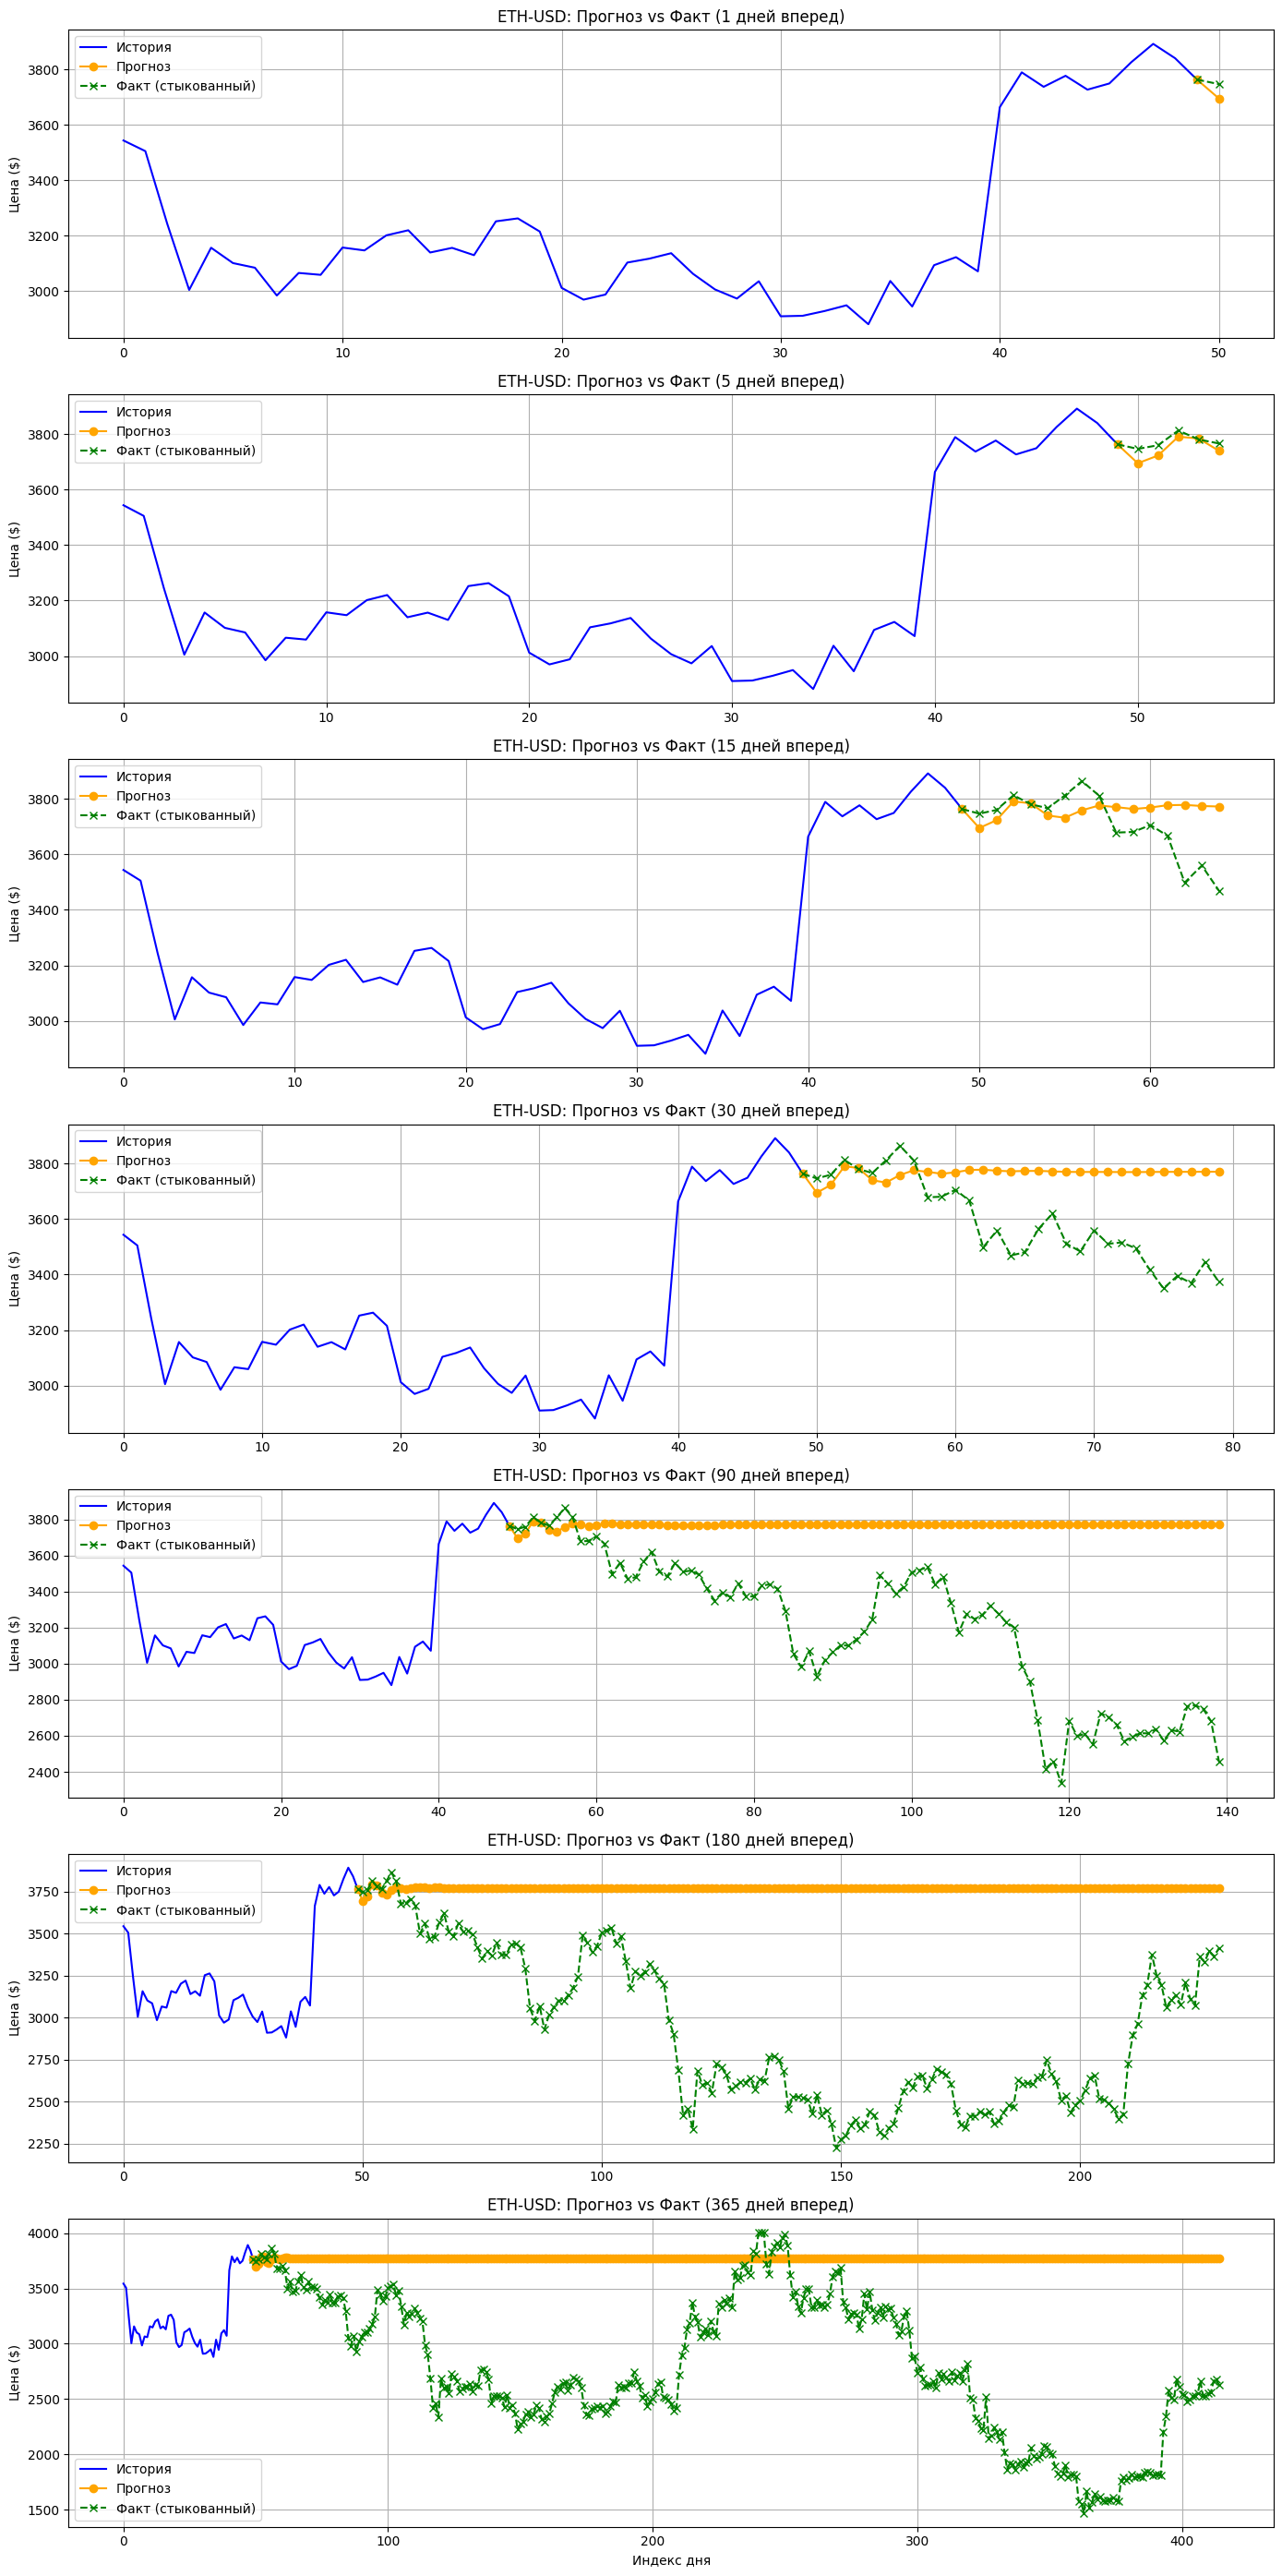

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Фиксируем точку, откуда будем прогнозировать
start_index = len(scaled_close) - 365  # например, последний год
start_window = scaled_features[start_index - window_size:start_index]

# Функция итеративного прогноза на h дней вперед
def get_forecast_from(start_window, h):
    preds = []
    current_window = start_window.copy()
    for _ in range(h):
        inp = torch.tensor(current_window[np.newaxis], dtype=torch.float32).to(device)
        with torch.no_grad():
            next_pred_scaled = model(inp).cpu().numpy()
        preds.append(next_pred_scaled.flatten()[0])
        next_features = current_window[-1].copy()
        next_features[0] = next_pred_scaled.flatten()[0]
        current_window = np.vstack([current_window[1:], next_features])
    preds = np.array(preds).reshape(-1, 1)
    return target_scaler.inverse_transform(preds)

# Горизонты прогноза
horizons = [1, 5, 15, 30, 90, 180, 365]
history_len = 50

# История: фиксированная часть до старта прогноза
real_prices = target_scaler.inverse_transform(scaled_close[start_index - history_len:start_index]).flatten()

# Визуализация
fig, axes = plt.subplots(len(horizons), 1, figsize=(14, 4 * len(horizons)), sharex=False)

for i, h in enumerate(horizons):
    # Прогноз и факт с одной и той же стартовой позиции
    forecast = get_forecast_from(start_window, h)
    true_future = target_scaler.inverse_transform(scaled_close[start_index : start_index + h]).flatten()

    # Подготовка координат
    forecast = np.insert(forecast.flatten(), 0, real_prices[-1])
    x_forecast = np.arange(history_len - 1, history_len + len(forecast) - 1)

    fact_y = np.concatenate([[real_prices[-1]], true_future])
    fact_x = np.arange(history_len - 1, history_len + len(true_future))

    # Построение графика
    ax = axes[i]
    ax.plot(np.arange(history_len), real_prices, label='История', color='blue')
    ax.plot(x_forecast, forecast, label='Прогноз', color='orange', marker='o')
    ax.plot(fact_x, fact_y, color="green", linestyle="--", marker="x", label="Факт (стыкованный)")
    ax.set_title(f'ETH-USD: Прогноз vs Факт ({h} дней вперед)')
    ax.set_ylabel('Цена ($)')
    ax.grid(True)
    ax.legend()

axes[-1].set_xlabel('Индекс дня')
plt.tight_layout()
plt.show()


## Выводы и возможные улучшения

В данной работе была реализована модель LSTM для прогноза цен Ethereum (ETH-USD) на различных горизонтах времени. Проведен анализ ее поведения на кратко- и долгосрочных прогнозах.

### Основные выводы:
- LSTM хорошо работает на коротком горизонте (1–5 дней), приближаясь к реальному значению и точно следуя локальным трендам.
- Качество заметно снижается при увеличении горизонта (30–365 дней) из-за накопления ошибок и потери контекста.
- Итеративный (autoregressive) подход имеет ограничение — ошибки накапливаются от шага к шагу, особенно при высокой волатильности.
- Простая архитектура LSTM без внешних факторов (технических индикаторов, новостей) не может моделировать сложные макроэкономические влияния.

### Потенциальные улучшения:
- Добавить дополнительные признаки: RSI, MACD, log-returns, объемы, волатильность и др.
- Заменить архитектуру: использовать Seq2Seq с Attention или Transformer-подходы (Informer, Temporal Fusion Transformer), чтобы избавиться от автогрессии и моделировать всю последовательность разом.
- Реализовать строгую отложенную выборку (out-of-sample валидацию) для оценки обобщающей способности модели.
- Добавить мультивалютные признаки: использовать BTC, LTC и другие активы в качестве входных данных.
- Реализовать инкрементальное обучение или online-learning подходы для обновления модели по мере поступления новых данных.


# Дополнительно. Определение фаз рынка

In [68]:
import pandas as pd
import numpy as np
import yfinance as yf

df = yf.download('ETH-USD', start='2017-01-01', interval='1d')

# Определим фазы рынка по SMA_21 и ее производной
df['SMA_21'] = df['Close'].rolling(window=21).mean()

# Логика определения фазы
df['Trend'] = np.where(df['SMA_21'].diff() > 0, 'bull', 'bear')
df['Trend'][df['SMA_21'].diff().abs() < 0.5] = 'flat'

# Очистим от NaN
df.dropna(inplace=True)

df.head()


[*********************100%***********************]  1 of 1 completed
<ipython-input-68-94ca695064ac>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Trend'][df['SMA_21'].diff().abs() < 0.5] = 'flat'
<ipython-input-68-94ca695064ac>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Trend'][df['SMA_21'].diff().abs() < 0.5] = 'flat'


Price,Close,High,Low,Open,Volume,SMA_21,Trend
Ticker,ETH-USD,ETH-USD,ETH-USD,ETH-USD,ETH-USD,,
Date,,,,,,,
2017-11-29,427.523010,522.307007,425.071014,473.281006,2675940096,376.523430,bear
2017-11-30,447.114014,465.497009,401.243011,431.214996,1903040000,382.534383,bull
2017-12-01,466.540009,472.609009,428.312012,445.209015,1247879936,390.500432,bull
2017-12-02,463.449005,476.239014,456.653015,466.851013,943649984,397.584622,bull
2017-12-03,465.852997,482.813995,451.851990,463.704987,990556992,405.105813,bull


Создание классов и окна

In [69]:
# Преобразуем тренды в числовые классы
df['Trend_label'] = df['Trend'].map({'bull': 0, 'bear': 1, 'flat': 2})

# Создание оконных данных
window_size = 30

X, y = [], []
for i in range(window_size, len(df)):
    X.append(df[['Close', 'SMA_21']].iloc[i-window_size:i].values)
    y.append(df['Trend_label'].iloc[i])

X, y = np.array(X), np.array(y)
X.shape, y.shape


((2709, 30, 2), (2709,))

In [70]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

class MarketTrendDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(MarketTrendDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(MarketTrendDataset(X_test, y_test), batch_size=64, shuffle=False)

class TrendClassifierLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TrendClassifierLSTM(input_size=2, hidden_size=64, num_layers=2, num_classes=3).to(device)


In [71]:
from sklearn.metrics import confusion_matrix, classification_report

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}')


Epoch 1/20, Loss: 0.7191
Epoch 2/20, Loss: 0.3388
Epoch 3/20, Loss: 0.2901
Epoch 4/20, Loss: 0.2815
Epoch 5/20, Loss: 0.2774
Epoch 6/20, Loss: 0.2808
Epoch 7/20, Loss: 0.2775
Epoch 8/20, Loss: 0.2566
Epoch 9/20, Loss: 0.2509
Epoch 10/20, Loss: 0.2478
Epoch 11/20, Loss: 0.2626
Epoch 12/20, Loss: 0.2545
Epoch 13/20, Loss: 0.2513
Epoch 14/20, Loss: 0.2439
Epoch 15/20, Loss: 0.2623
Epoch 16/20, Loss: 0.2490
Epoch 17/20, Loss: 0.2561
Epoch 18/20, Loss: 0.2422
Epoch 19/20, Loss: 0.2489
Epoch 20/20, Loss: 0.2354


In [72]:
from sklearn.metrics import confusion_matrix, classification_report

# Модель в режиме оценки
model.eval()
all_preds, all_targets = [], []

# Прогнозирование
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(y_batch.numpy())

# Определим все возможные метки (например: 0 = Bull, 1 = Bear, 2 = Flat)
labels = [0, 1, 2]
target_names = ['Bull', 'Bear', 'Flat']

# Матрица ошибок
cm = confusion_matrix(all_targets, all_preds, labels=labels)
print("Confusion Matrix:")
print(cm)

# Классификационный отчет
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, labels=labels, target_names=target_names, zero_division=0))


Confusion Matrix:
[[219  25   0]
 [ 24 274   0]
 [  0   0   0]]

Classification Report:
              precision    recall  f1-score   support

        Bull       0.90      0.90      0.90       244
        Bear       0.92      0.92      0.92       298
        Flat       0.00      0.00      0.00         0

    accuracy                           0.91       542
   macro avg       0.61      0.61      0.61       542
weighted avg       0.91      0.91      0.91       542


In [ ]:
# !pip install ta

In [73]:
# Возьмем последние 30 дней для прогноза
last_window = df[['Close', 'SMA_21']].iloc[-window_size:].values
last_window = torch.tensor(last_window[np.newaxis], dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    pred = model(last_window).argmax(dim=1).item()

phase_names = ['Бычий тренд', 'Медвежий тренд', 'Флет']
current_phase = phase_names[pred]

print(f"Текущая фаза рынка: {current_phase}")


Текущая фаза рынка: Бычий тренд


<Figure size 1600x600 with 0 Axes>

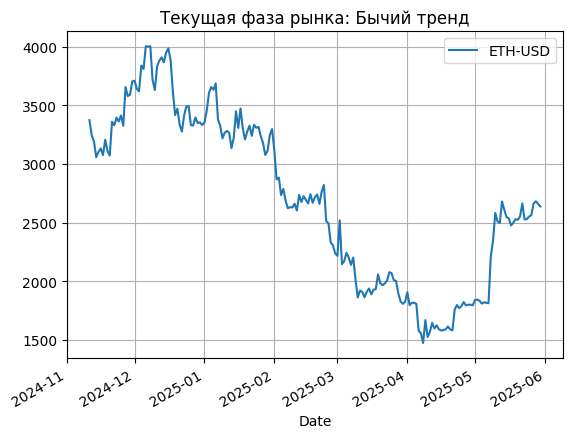

In [74]:
plt.figure(figsize=(16,6))
df['Close'].iloc[-200:].plot(label='Цена ETH-USD')

# Отметим текущую фазу
plt.title(f"Текущая фаза рынка: {current_phase}")
plt.legend()
plt.grid(True)
plt.show()
